## Get the light curve

```collections = 'LSSTComCamSim/runs/DRP/OR4/w_2024_25/DM-45066'```

```skymap = 'ops_rehersal_prep_2k_v1'```

1. Select a tract and patch which has a good deepcoadd image in g, r, i bands
2. From this patch, pick an (ra, dec) which has the highest g band flux from the ObjectTable (just so that we know it actually got observed) 
4. Ask James’ function what truth parquet files overlap this (ra, dec)
5. For each of these truth tables
    - Select variable objects and 17 < magnorm < 19
    - cross match the truth file with the ObjectTable to find objects within 2 arcsec
    - We will ge the light curve for this closes match object. Get the (ra, dec), magnorm, mag_amplitude, period, and phase for this object
3. Ask the skymap what (tract, patch) the (ra, dec) lies in
4. Find the closest match for this (ra, dec) from diaObjectTable_tract. Get the diaObjectId
5. For this diaObjectId, get the flux from diaSourceTable_tract
6. Convert nJy to mag. Get the error based on nJy flux
   
   ```g_mag = (scienceFlux*u.nJy).to(u.ABmag).value```
   
   ```g_mag_err = 1.09*'scienceFluxErr/'scienceFlux'```

### Equation to calculate the true magnitude from the pipeline mjd

```truth_magnitude_at_time_of_visit = magnorm + mag_amplitude*sin(2.*pi*(mjd - mjd0)/period + phase)```

```where mjd0 = 60400 and mjd = mjdMidpointTai```  

<font color='red'>1. Which band does this equation give the flux for?</font> 

<font color='red'>2. Why is there an offset between true and pipeline flux?<font>

<font color='red'>3. Some patches which have deepCoadd images do not have ObjecTable e.g. patch 208<font>

In [1]:
# Standard imports:
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.units as u

import glob as glob
import os

from astropy.coordinates import Angle
import lsst.geom

In [2]:
afwDisplay.setDefaultBackend('matplotlib')
from lsst.rsp import get_tap_service
service = get_tap_service("tap")

In [3]:
# A funuction to determine the filename of a truthtable covering a DIA detecor image.
def GetTruthFiles(RA, Dec):
    '''
    Given a set of coordinates, determine the filename of the pointsource parquet
    truth table that covers that region. This is needed because the parquet files
    are named according to the htm7 nside=32 region that they cover, so the index
    of the htm7 segment is needed to identify the file.

    Note
    ----
    This calculates the mean coordinate of the catalogue and uses that to
    determine the htm7 segment.

    Inputs
    ------
    RA: Pandas series containing the Right Ascention of sources in degrees.
    Dec: Pandas series containing the Deckination of sources in degrees.

    Outputs
    -------
    truthFiles: List of filenames of the truth table parquet files that cover the
                region of interest.
    
    '''
    truthFiles = []

    mean_ra = np.deg2rad(np.mean(RA.value))
    mean_de = np.deg2rad(90. - np.mean(Dec.value))
    coordVec = hp.ang2vec(mean_de, mean_ra)
    ipix_discs = hp.query_disc(nside=32, vec=coordVec, radius=np.radians(2))

    for ipix_disc in ipix_discs:
        filename = '/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_{}.parquet'.format(ipix_disc)
        if os.path.exists(filename):
            truthFiles.append(filename)        
    return truthFiles

In [4]:
# Butler setup and skyMap retrieval:
collections = 'LSSTComCamSim/runs/DRP/OR4/w_2024_25/DM-45066'
butler = dafButler.Butler('embargo_or4', collections=collections)
registry = butler.registry
skyMap = butler.get('skyMap', dataId={'skymap':'ops_rehersal_prep_2k_v1'})

In [5]:
# # select a tract and patch
# for i, dt in enumerate(registry.queryDatasets(datasetType='goodSeeingCoadd', collections=collections)):
#     # print(dt.dataId['tract'])
#     if 100 < i < 200:
#         print(dt.dataId)

In [6]:
# select_tract = 2494
# select_patch = 275
# select_tract = 2494
# select_patch = 155
# select_tract = 2494
# select_patch = 204
select_tract = 2494
select_patch = 138

In [7]:
# tract_dataid = {'band': 'g', 'skymap': 'ops_rehersal_prep_2k_v1', 'tract': select_tract, 'patch': select_patch}
# tract_im = butler.get('deepCoadd', dataId=tract_dataid)

# fig = plt.figure(figsize=(10, 8))
# afw_display = afwDisplay.Display(1)
# afw_display.scale('asinh', 'zscale')
# afw_display.mtv(tract_im.image)
# plt.gca().axis('on')
# plt.show()
# plt.close()

In [8]:
# tract_dataid = {'band': 'i', 'skymap': 'ops_rehersal_prep_2k_v1', 'tract': select_tract, 'patch': select_patch}
# tract_im = butler.get('deepCoadd', dataId=tract_dataid)

# fig = plt.figure(figsize=(10, 8))
# afw_display = afwDisplay.Display(1)
# afw_display.scale('asinh', 'zscale')
# afw_display.mtv(tract_im.image)
# plt.gca().axis('on')
# plt.show()
# plt.close()

In [9]:
# tract_dataid = {'band': 'r', 'skymap': 'ops_rehersal_prep_2k_v1', 'tract': select_tract, 'patch': select_patch}
# tract_im = butler.get('deepCoadd', dataId=tract_dataid)

# fig = plt.figure(figsize=(10, 8))
# afw_display = afwDisplay.Display(1)
# afw_display.scale('asinh', 'zscale')
# afw_display.mtv(tract_im.image)
# plt.gca().axis('on')
# plt.show()
# plt.close()

### Select ra, dec from object table

In [10]:
tract_dataid = {'band': 'g', 'skymap': 'ops_rehersal_prep_2k_v1', 'tract': select_tract, 'patch': select_patch}
obj_table = butler.get('objectTable', dataId=tract_dataid)
obj_table = obj_table.reset_index()

# select a bright object from g band 
obj_table = obj_table[obj_table['refBand'] == 'g']
obj_table = obj_table.sort_values('g_psfFlux', ascending=False) 

In [11]:
obj_table['g_psfFlux'][0:5]

519     1.367933e+06
894     1.343890e+06
4854    1.343887e+06
561     1.300445e+06
3603    1.300381e+06
Name: g_psfFlux, dtype: float64

In [12]:
obj_table.head()

column,objectId,footprintArea,deblend_nChild,coord_ra,deblend_logL,refSizeExtendedness,merge_peak_sky,coord_dec,deblend_parentTooBig,refFwhm,...,y_kronFlux_flag,y_kronFlux_flag_bad_radius,y_kronFlux_flag_bad_shape,y_kronFlux_flag_bad_shape_no_psf,y_kronFlux_flag_edge,y_kronFlux_flag_no_fallback_radius,y_kronFlux_flag_no_minimum_radius,y_kronFlux_flag_small_radius,y_kronFlux_flag_used_minimum_radius,y_kronFlux_flag_used_psf_radius
519,792642330510230237,29883,51,279.621379,-2.835757e+06,0.999454,False,-48.348584,False,0.769454,...,True,True,True,True,True,True,True,True,True,True
894,792642330510230784,6451,16,279.625746,-4.302940e+05,0.004691,False,-48.326706,False,0.762062,...,True,True,True,True,True,True,True,True,True,True
4854,792642330510236795,1821,0,279.625746,NaN,0.004691,False,-48.326706,False,0.762062,...,True,True,True,True,True,True,True,True,True,True
561,792642330510230302,10449,20,279.548658,-6.590139e+07,0.000331,False,-48.354173,False,0.754383,...,True,True,True,True,True,True,True,True,True,True
3603,792642330510235544,853,0,279.548658,NaN,0.000329,False,-48.354173,False,0.754383,...,True,True,True,True,True,True,True,True,True,True


In [13]:
# obj_table.columns.to_list()

In [14]:
obj_ra = obj_table['coord_ra'].values[0]
obj_dec = obj_table['coord_dec'].values[0]

### Get truth files for this ra, dec

In [15]:
def find_match_truth_objtable(truthfile, obj_table):
    print(truthFile)
    truthTable = pd.read_parquet(truthFile)
    
    # select variable stars
    truthTable = truthTable[truthTable['is_variable'] == True]
    truthTable = truthTable.sort_values('magnorm', ascending=True)
    truthTable = truthTable[(truthTable['magnorm'] > 17.0) & (truthTable['magnorm'] < 19.0)]
    
    # cross match with the object table
    trueCoords = SkyCoord(ra=truthTable['ra'].values*u.degree, dec=truthTable['dec'].values*u.degree)
    objCoords = SkyCoord(ra=obj_table['coord_ra'].values*u.degree, dec=obj_table['coord_dec'].values*u.degree)

    idx, d2d, d3d = objCoords.match_to_catalog_sky(trueCoords) # idx is closest index in trueCoords

    # print('length of objCoords table: ',len(objCoords))
    # print('length of indices: ',len(idx))

    # select closest matche within 2"
    d2d_inx = np.where(d2d < 2*u.arcsec)
    idx = idx[d2d_inx]
    d2d = d2d[d2d_inx]

    print(idx)
    return truthFile, idx

In [16]:
for truthFile in GetTruthFiles(obj_ra*u.degree, obj_dec*u.degree):
    truthfile, idx = find_match_truth_objtable(truthFile, obj_table)
    # print(truthfile)
    # print(idx)
    # print(len(idx))
    if len(idx) != 0:
        truthfile_match = truthfile
        idx_match = idx[0]

/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_10638.parquet
[]
/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_10750.parquet
[]
/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_10751.parquet
[]
/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_10859.parquet
[873]
/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_10860.parquet
[]


In [17]:
print(truthfile_match)
print(idx_match)

/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_10859.parquet
873


In [18]:
# select variable star from the truth table where there is a match for the (ra,dec) from the object table

truthTable = pd.read_parquet(str(truthfile_match))
    
truthTable = truthTable[truthTable['is_variable'] == True]
truthTable = truthTable.sort_values('magnorm', ascending=True)
truthTable = truthTable[(truthTable['magnorm'] > 17.0) & (truthTable['magnorm'] < 19.0)]

In [19]:
# truthTable.columns.to_list()

In [20]:
truthTable[idx_match:idx_match+1]

,object_type,id,ra,dec,host_galaxy_id,magnorm,sed_filepath,MW_rv,MW_av,mura,mudec,radial_velocity,parallax,variability_model,salt2_params,is_variable,period,mag_amplitude,phase
959358,star,40263938636,279.670755,-48.287039,0,17.387506,starSED/kurucz/km15_5250.fits_g05_5450.gz,3.1,0.158888,0.12,-11.48,16.82,0.445656,,None,True,7.640661,0.294021,1.00468


In [21]:
# read all the values that we want to calculate the true flux 

bright_magnorm = truthTable['magnorm'][idx_match:idx_match+1].values[0]
bright_period = truthTable['period'][idx_match:idx_match+1].values[0]
bright_magamp = truthTable['mag_amplitude'][idx_match:idx_match+1].values[0]
bright_phase = truthTable['phase'][idx_match:idx_match+1].values[0]
bright_ra = truthTable['ra'][idx_match:idx_match+1].values[0]
bright_dec = truthTable['dec'][idx_match:idx_match+1].values[0]

In [22]:
print('selected ra, dec from objectTable: ', obj_ra, obj_dec)
print('matched true ra, dec: ', bright_ra, bright_dec)

selected ra, dec from objectTable:  279.6213788871078 -48.34858392071148
matched true ra, dec:  279.6707547 -48.2870387


In [23]:
# check the tract and patch that this bright (ra, dec) belongs to
my_spherePoint = lsst.geom.SpherePoint(bright_ra*lsst.geom.degrees,
                                       bright_dec*lsst.geom.degrees)
print(my_spherePoint)

tract = skyMap.findTract(my_spherePoint)
patch = tract.findPatch(my_spherePoint)

my_tract = tract.tract_id
my_patch = patch.getSequentialIndex()

print('tract of true ra,dec: ', my_tract)
print('patch of true ra,dec: ', my_patch)

(279.6707547000, -48.2870387000)
tract of true ra,dec:  2494
patch of true ra,dec:  155


In [24]:
# Check if this tact and pacth exist in ops_rehersal
match_tract_dataid = {'band': 'g', 'skymap': 'ops_rehersal_prep_2k_v1', 'tract': my_tract, 'patch': my_patch}

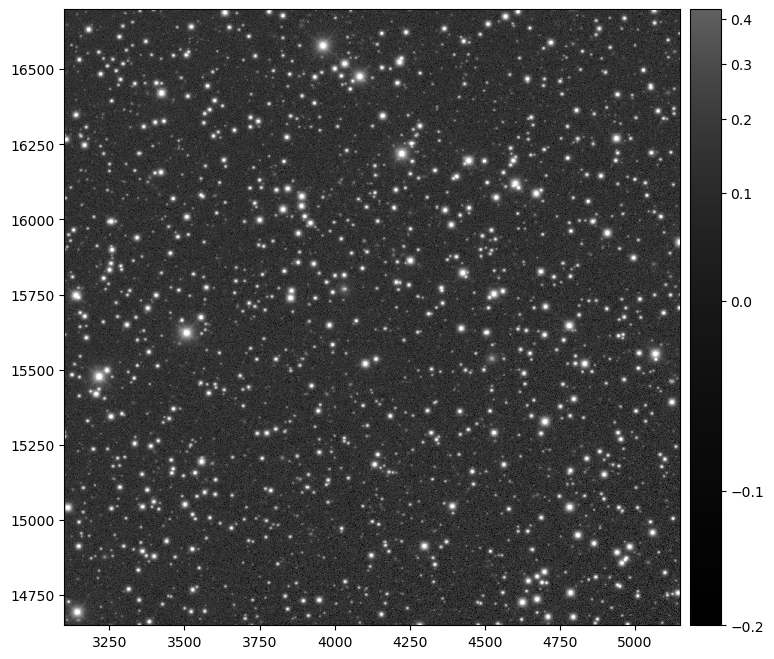

In [25]:
tract_im = butler.get('deepCoadd', dataId=match_tract_dataid)

fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(tract_im.image)
plt.gca().axis('on')
plt.show()
plt.close()

## match the bright ra and dec from truth table to diaObjectTable_tract

In [26]:
tract_gSOTable = butler.get('diaObjectTable_tract', tract=my_tract, patch=my_patch, skymap = 'ops_rehersal_prep_2k_v1')

In [27]:
trueCoords = SkyCoord(ra=bright_ra*u.degree, dec=bright_dec*u.degree)
diaCoords = SkyCoord(ra=tract_gSOTable['ra'].values*u.degree, dec=tract_gSOTable['dec'].values*u.degree)

idx, d2d, d3d = trueCoords.match_to_catalog_sky(diaCoords) #idx is closest index in diaCoords

print(idx)

293104


In [28]:
tract_gSOTable[int(idx):int(idx+1)]

,ra,dec,nDiaSources,radecMjdTai,g_psfFluxLinearSlope,g_psfFluxLinearIntercept,g_psfFluxMAD,g_psfFluxMaxSlope,g_psfFluxErrMean,g_psfFluxMean,...,i_psfFluxPercentile05,i_psfFluxPercentile25,i_psfFluxPercentile50,i_psfFluxPercentile75,i_psfFluxPercentile95,i_psfFluxSigma,i_scienceFluxSigma,i_psfFluxSkew,i_psfFluxChi2,i_psfFluxStetsonJ
diaObjectId,,,,,,,,,,,,,,,,,,,,,
792661022207901930,279.670758,-48.287039,207,60489.408538,18640.735446,-1.127458e+09,20809.974119,1.949253e+07,627.240223,84886.683857,...,95905.529175,113604.39618,177950.192998,211575.540373,223035.112892,49495.461027,51794.001703,-0.132075,200647.975506,49.972334


In [29]:
diaobj_ra = tract_gSOTable[int(idx):int(idx+1)]['ra']
diaobj_dec = tract_gSOTable[int(idx):int(idx+1)]['dec']

In [30]:
diaobj_id = tract_gSOTable[int(idx):int(idx+1)].index[0]

In [31]:
print('true ra, dec: ', bright_ra, bright_dec)
print('matched to diaObjectTable_tract ra, dec: ', diaobj_ra.values[0], diaobj_dec.values[0])

true ra, dec:  279.6707547 -48.2870387
matched to diaObjectTable_tract ra, dec:  279.67075798502805 -48.28703944133624


## Get flux from diaSourceTable_tract based on diaObjectId from diaObjectTable_tract

In [32]:
tract_gSDTable = butler.get('diaSourceTable_tract', tract=my_tract, patch=my_patch, skymap = 'ops_rehersal_prep_2k_v1')

In [33]:
selected_obj = tract_gSDTable[(tract_gSDTable['diaObjectId'] == diaobj_id)]

In [34]:
selected_obj

,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,ra,...,shape_flag_parent_source,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,coord_ra,coord_dec
diaSourceId,,,,,,,,,,,,,,,,,,,,,
3068394065482483304,7024062500149,0,r,792661022207901930,0,0,60487.064414,51,2024-07-02 02:06:40.845606,279.670742,...,False,False,False,False,False,False,False,False,279.670758,-48.287039
3068394678593258978,7024062500720,1,i,792661022207901930,0,0,60487.374914,47,2024-07-02 02:20:38.897789,279.670765,...,False,False,False,False,False,False,False,False,279.670758,-48.287039
3068394688256934789,7024062500729,1,i,792661022207901930,0,0,60487.379124,44,2024-07-02 01:26:42.042684,279.670746,...,False,False,False,False,False,False,False,False,279.670758,-48.287039
3068394692551901635,7024062500733,1,g,792661022207901930,0,0,60487.382346,45,2024-07-02 02:04:04.350356,279.670743,...,False,False,False,False,False,False,False,False,279.670758,-48.287039
3068429874776506462,7024062600731,1,r,792661022207901930,0,0,60488.403573,47,2024-07-02 01:40:17.408406,279.670768,...,False,False,False,False,False,False,False,False,279.670758,-48.287039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3068429529060999968,7024062600409,8,r,792661022207901930,0,0,60488.218213,34,2024-07-02 01:52:38.728379,279.670751,...,False,False,False,False,False,False,False,False,279.670758,-48.287039
3068429535503451918,7024062600415,8,r,792661022207901930,0,0,60488.221033,38,2024-07-02 02:01:03.732006,279.670764,...,False,False,False,False,False,False,False,False,279.670758,-48.287039
3068429547314611539,7024062600426,8,r,792661022207901930,0,0,60488.226193,37,2024-07-02 02:27:33.568251,279.670746,...,False,False,False,False,False,False,False,False,279.670758,-48.287039


In [35]:
# selected_obj.columns.to_list()

## Plot the light curve

In [36]:
# mjd = selected_obj['midpointMjdTai']
# flux = selected_obj['scienceFlux']
df_g = selected_obj.loc[selected_obj['band'] == 'g', ['visit', 'detector', 'midpointMjdTai', 'ra', 'dec', 'scienceFlux', 'scienceFluxErr', 'psfFlux', 'psfFluxErr']]
df_r = selected_obj.loc[selected_obj['band'] == 'r', ['visit', 'detector','midpointMjdTai', 'ra', 'dec', 'scienceFlux', 'scienceFluxErr', 'psfFlux', 'psfFluxErr']]
df_i = selected_obj.loc[selected_obj['band'] == 'i', ['visit', 'detector','midpointMjdTai', 'ra', 'dec', 'scienceFlux', 'scienceFluxErr', 'psfFlux', 'psfFluxErr']]

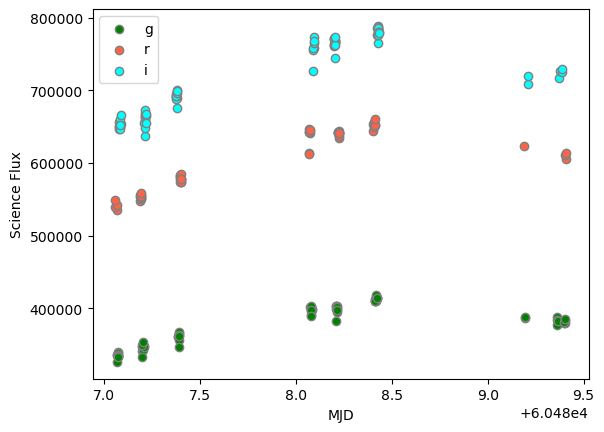

In [37]:
plt.scatter(df_g['midpointMjdTai'], df_g['scienceFlux'], edgecolor = 'grey', color='g', label='g')
plt.scatter(df_r['midpointMjdTai'], df_r['scienceFlux'], edgecolor = 'grey', color='tomato', label='r')
plt.scatter(df_i['midpointMjdTai'], df_i['scienceFlux'], edgecolor = 'grey', color='cyan', label='i')
plt.xlabel('MJD')
plt.ylabel('Science Flux')
plt.legend()

## Calculate the true light curve flux

In [38]:
mjd0 = 60400

In [39]:
# covert nJy flux to mag
g_mag = (df_g['scienceFlux'].to_numpy()*u.nJy).to(u.ABmag).value
r_mag = (df_r['scienceFlux'].to_numpy()*u.nJy).to(u.ABmag).value
i_mag = (df_i['scienceFlux'].to_numpy()*u.nJy).to(u.ABmag).value

In [40]:
# calculate the error in mag
g_mag_err = 1.09*df_g['scienceFluxErr'].to_numpy()/df_g['scienceFlux'].to_numpy()
r_mag_err = 1.09*df_r['scienceFluxErr'].to_numpy()/df_r['scienceFlux'].to_numpy()
i_mag_err = 1.09*df_i['scienceFluxErr'].to_numpy()/df_i['scienceFlux'].to_numpy()

In [41]:
# calculate the true flux based on the equation

truth_magnitude_g = np.array([bright_magnorm + bright_magamp*np.sin(2.*np.pi*(mjd - mjd0)/bright_period + bright_phase) for mjd in df_g['midpointMjdTai'].to_numpy()])
truth_magnitude_r = np.array([bright_magnorm + bright_magamp*np.sin(2.*np.pi*(mjd - mjd0)/bright_period + bright_phase) for mjd in df_r['midpointMjdTai'].to_numpy()])
truth_magnitude_i = np.array([bright_magnorm + bright_magamp*np.sin(2.*np.pi*(mjd - mjd0)/bright_period + bright_phase) for mjd in df_i['midpointMjdTai'].to_numpy()])

## Compare the true flux with the pipeline flux

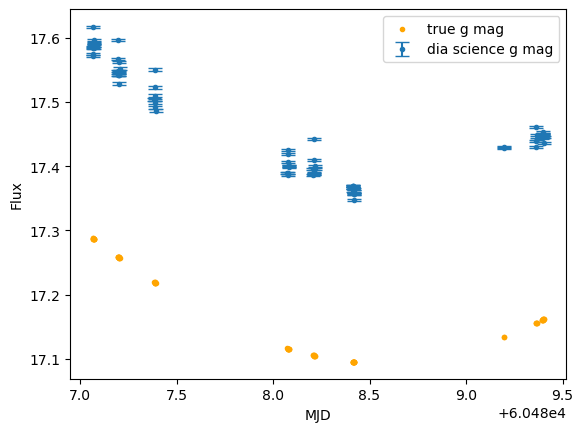

In [42]:
plt.errorbar(df_g['midpointMjdTai'].to_numpy(), g_mag, yerr=g_mag_err, fmt='.', capsize=5, label='dia science g mag')
plt.scatter(df_g['midpointMjdTai'].to_numpy(), truth_magnitude_g, color='orange', marker='.', label='true g mag')
plt.xlabel('MJD')
plt.ylabel('Flux')
plt.legend()

Text(0, 0.5, 'dia science - true g')

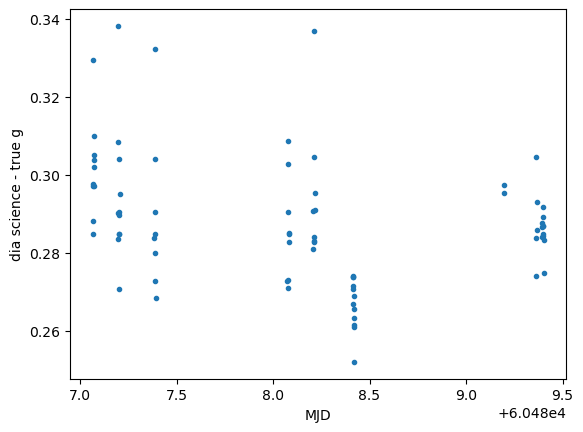

In [43]:
# find the difference between true and pipeline flux
g_diff = (g_mag - truth_magnitude_g)
plt.scatter(df_g['midpointMjdTai'].to_numpy(), g_diff, marker='.')
plt.xlabel('MJD')
plt.ylabel('dia science - true g')

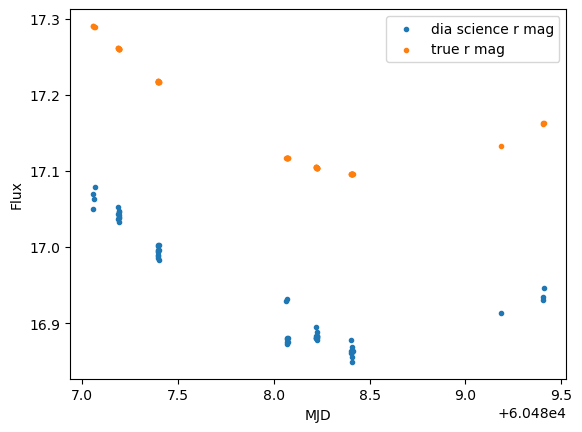

In [44]:
plt.scatter(df_r['midpointMjdTai'].to_numpy(), r_mag, marker='.', label='dia science r mag')
plt.scatter(df_r['midpointMjdTai'].to_numpy(), truth_magnitude_r, marker='.', label='true r mag')
plt.xlabel('MJD')
plt.ylabel('Flux')
plt.legend()

Text(0, 0.5, 'dia science - true r')

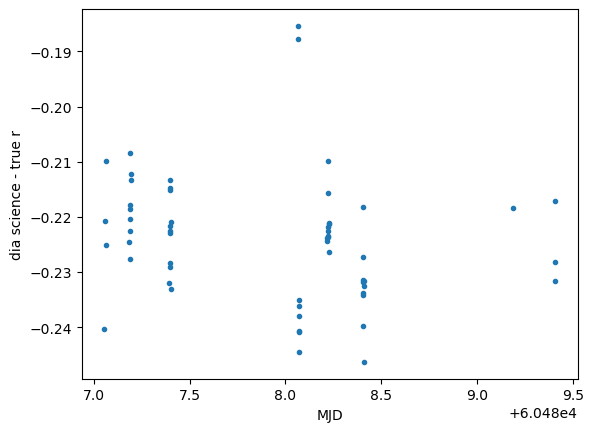

In [45]:
# find the difference between true and pipeline flux
r_diff = (r_mag - truth_magnitude_r)
plt.scatter(df_r['midpointMjdTai'].to_numpy(), r_diff, marker='.')
plt.xlabel('MJD')
plt.ylabel('dia science - true r')

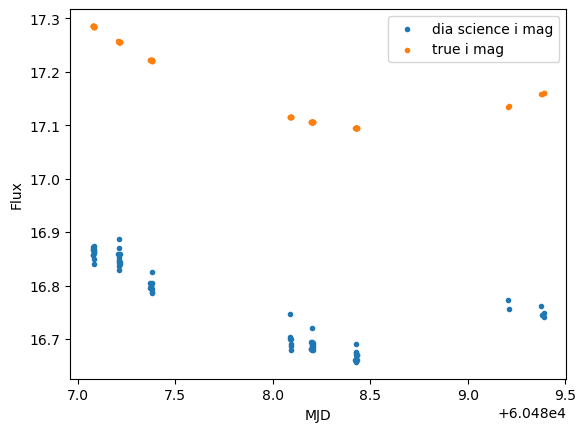

In [46]:
plt.scatter(df_i['midpointMjdTai'].to_numpy(), i_mag, marker='.', label='dia science i mag')
plt.scatter(df_i['midpointMjdTai'].to_numpy(), truth_magnitude_i, marker='.', label='true i mag')
plt.xlabel('MJD')
plt.ylabel('Flux')
plt.legend()

Text(0, 0.5, 'dia science - true i')

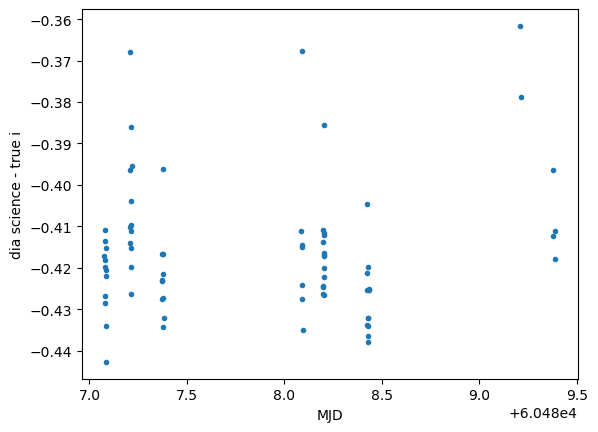

In [47]:
# find the difference between true and pipeline flux
i_diff = (i_mag - truth_magnitude_i)
plt.scatter(df_i['midpointMjdTai'].to_numpy(), i_diff, marker='.')
plt.xlabel('MJD')
plt.ylabel('dia science - true i')

In [48]:
def get_srcflux(visit, detector, ra, dec):
    """
    Function to get the calexp flux from sourceTable given the dataId from diaSourceTable_tract
    
    Match the ra, dec from diaSourceTable_tract with sourceTable

    """
    dataId = {'visit': visit, 'detector': detector}
    src = butler.get('sourceTable', dataId)
    # match dia coord to the source coord
    srcCoords = SkyCoord(ra=src['coord_ra'].values*u.degree, dec=src['coord_dec'].values*u.degree)
    diaCoords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree)
    
    idx, d2d, d3d = diaCoords.match_to_catalog_sky(srcCoords, nthneighbor=1) #idx is closest index in diaCoords
    # print(idx)
    src_match = src[src.index == src.index[int(idx)]]
    psf_flux = src_match['psfFlux'].values[0]
    psf_flux_err = src_match['psfFluxErr'].values[0]

    mag_err = 1.09*psf_flux_err/psf_flux
    mag = (psf_flux*u.nJy).to(u.ABmag).value

    return mag, mag_err

In [49]:
src_psf_flux_g = []
src_psf_fluxerr_g = []

for i in range(0, len(df_g)):
    visit = df_g['visit'].iloc[[i]].values[0]
    detector = df_g['detector'].iloc[[i]].values[0]
    ra = df_g['ra'].iloc[[i]].values[0]
    dec = df_g['dec'].iloc[[i]].values[0]
    mag, mag_err = get_srcflux(visit, detector, ra, dec)
    src_psf_flux_g.append(mag)
    src_psf_fluxerr_g.append(mag_err)

src_psf_flux_g = np.array(src_psf_flux_g)
src_psf_fluxerr_g = np.array(src_psf_fluxerr_g)

In [50]:
src_psf_flux_r = []
src_psf_fluxerr_r = []

for i in range(0, len(df_r)):
    visit = df_r['visit'].iloc[[i]].values[0]
    detector = df_r['detector'].iloc[[i]].values[0]
    ra = df_r['ra'].iloc[[i]].values[0]
    dec = df_r['dec'].iloc[[i]].values[0]
    mag, mag_err = get_srcflux(visit, detector, ra, dec)
    src_psf_flux_r.append(mag)
    src_psf_fluxerr_r.append(mag_err)

src_psf_flux_r = np.array(src_psf_flux_r)
src_psf_fluxerr_r = np.array(src_psf_fluxerr_r)

In [51]:
src_psf_flux_i = []
src_psf_fluxerr_i = []

for i in range(0, len(df_i)):
    visit = df_i['visit'].iloc[[i]].values[0]
    detector = df_i['detector'].iloc[[i]].values[0]
    ra = df_i['ra'].iloc[[i]].values[0]
    dec = df_i['dec'].iloc[[i]].values[0]
    mag, mag_err = get_srcflux(visit, detector, ra, dec)
    src_psf_flux_i.append(mag)
    src_psf_fluxerr_i.append(mag_err)

src_psf_flux_i = np.array(src_psf_flux_i)
src_psf_fluxerr_i = np.array(src_psf_fluxerr_i)

### Compare the true flux with calexp and dia flux

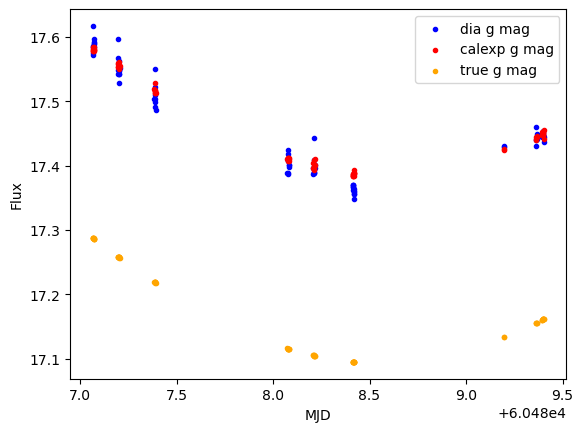

In [52]:
plt.scatter(df_g['midpointMjdTai'].to_numpy(), g_mag, marker='.', color = 'b', label='dia g mag')
plt.scatter(df_g['midpointMjdTai'].to_numpy(), src_psf_flux_g, marker='.', color = 'r', label='calexp g mag')
plt.scatter(df_g['midpointMjdTai'].to_numpy(), truth_magnitude_g, color='orange', marker='.', label='true g mag')
plt.xlabel('MJD')
plt.ylabel('Flux')
plt.legend()

Text(0, 0.5, 'calexp psf - dia science flux g')

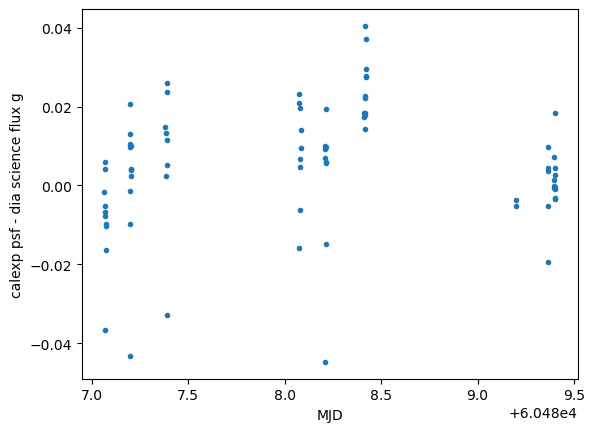

In [53]:
# find the difference between true and pipeline flux
calexp_dia_diff_g = (src_psf_flux_g - g_mag)
plt.scatter(df_g['midpointMjdTai'].to_numpy(), calexp_dia_diff_g, marker='.')
plt.xlabel('MJD')
plt.ylabel('calexp psf - dia science flux g')

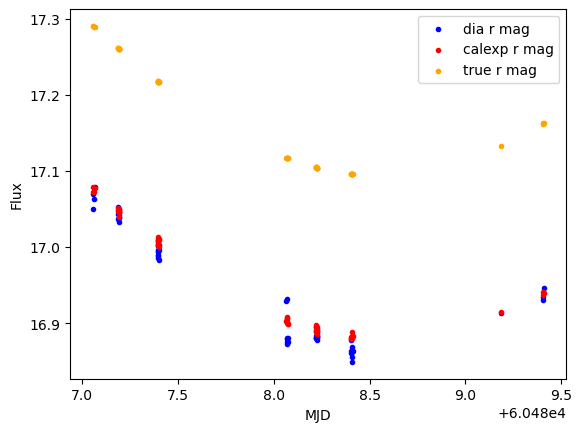

In [54]:
plt.scatter(df_r['midpointMjdTai'].to_numpy(), r_mag, marker='.', color = 'b', label='dia r mag')
plt.scatter(df_r['midpointMjdTai'].to_numpy(), src_psf_flux_r, marker='.', color = 'r', label='calexp r mag')
plt.scatter(df_r['midpointMjdTai'].to_numpy(), truth_magnitude_r, color='orange', marker='.', label='true r mag')
plt.xlabel('MJD')
plt.ylabel('Flux')
plt.legend()

Text(0, 0.5, 'calexp psf - dia science flux r')

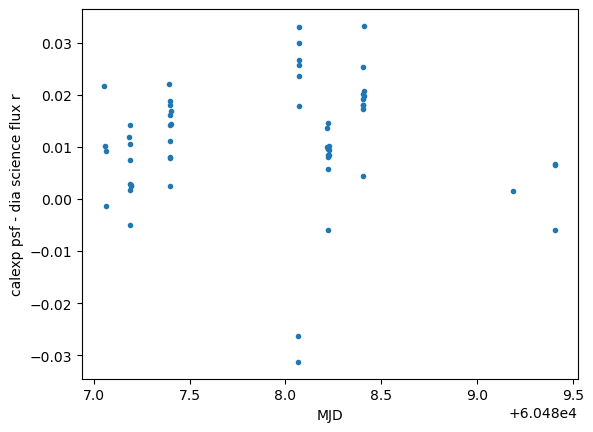

In [55]:
# find the difference between true and pipeline flux
calexp_dia_diff_r = (src_psf_flux_r - r_mag)
plt.scatter(df_r['midpointMjdTai'].to_numpy(), calexp_dia_diff_r, marker='.')
plt.xlabel('MJD')
plt.ylabel('calexp psf - dia science flux r')

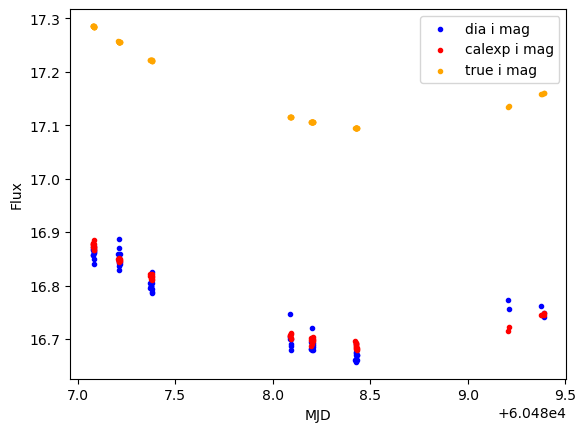

In [56]:
plt.scatter(df_i['midpointMjdTai'].to_numpy(), i_mag, marker='.', color = 'b', label='dia i mag')
plt.scatter(df_i['midpointMjdTai'].to_numpy(), src_psf_flux_i, marker='.', color = 'r', label='calexp i mag')
plt.scatter(df_i['midpointMjdTai'].to_numpy(), truth_magnitude_i, color='orange', marker='.', label='true i mag')
plt.xlabel('MJD')
plt.ylabel('Flux')
plt.legend()

Text(0, 0.5, 'calexp psf - dia science flux i')

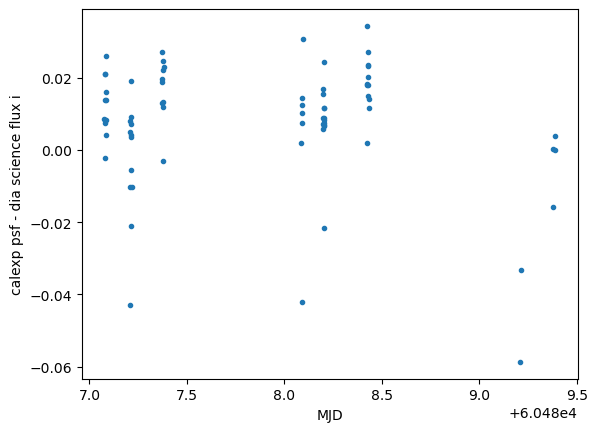

In [57]:
# find the difference between true and pipeline flux
calexp_dia_diff_i = (src_psf_flux_i - i_mag)
plt.scatter(df_i['midpointMjdTai'].to_numpy(), calexp_dia_diff_i, marker='.')
plt.xlabel('MJD')
plt.ylabel('calexp psf - dia science flux i')